In [90]:
import pandas as pd
import json
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import nltk
from nltk.corpus import stopwords

In [91]:
# Download stopwords if not available
nltk.download('stopwords')
# Set stopwords
stop_words = set(stopwords.words("english"))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Load JSONL file into a DataFrame


In [92]:
def load_jsonl(file_path):
    data = []
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            data.append(json.loads(line))
    return pd.DataFrame(data)
# Load training and validation data
train_df = load_jsonl('train.jsonl')
val_df = load_jsonl('validation.jsonl')

In [93]:
train_df.head()

,uuid,postId,postText,postPlatform,targetParagraphs,targetTitle,targetDescription,targetKeywords,targetMedia,targetUrl,provenance,spoiler,spoilerPositions,tags
0,0af11f6b-c889-4520-9372-66ba25cb7657,532quh,"[Wes Welker Wanted Dinner With Tom Brady, But ...",reddit,[It’ll be just like old times this weekend for...,"Wes Welker Wanted Dinner With Tom Brady, But P...",It'll be just like old times this weekend for ...,"new england patriots, ricky doyle, top stories,","[http://pixel.wp.com/b.gif?v=noscript, http://...",http://nesn.com/2016/09/wes-welker-wanted-dinn...,"{'source': 'anonymized', 'humanSpoiler': 'They...",[how about that morning we go throw?],"[[[3, 151], [3, 186]]]",[passage]
1,b1a1f63d-8853-4a11-89e8-6b2952a393ec,411701128456593408,[NASA sets date for full recovery of ozone hole],Twitter,[2070 is shaping up to be a great year for Mot...,Hole In Ozone Layer Expected To Make Full Reco...,2070 is shaping up to be a great year for Moth...,"ozone layer,ozone hole determined by weather,M...",[http://s.m.huffpost.com/assets/Logo_Huffingto...,http://huff.to/1cH672Z,"{'source': 'anonymized', 'humanSpoiler': '2070...",[2070],"[[[0, 0], [0, 4]]]",[phrase]
2,008b7b19-0445-4e16-8f9e-075b73f80ca4,380537005123190784,[This is what makes employees happy -- and it'...,Twitter,"[Despite common belief, money isn't the key to...",Intellectual Stimulation Trumps Money For Empl...,By: Chad Brooks \r\nPublished: 09/18/2013 06:4...,"employee happiness money,employee happiness in...",[http://i.huffpost.com/gen/1359674/images/o-HA...,http://huff.to/1epfeaw,"{'source': 'anonymized', 'humanSpoiler': 'Inte...",[intellectual stimulation],"[[[1, 186], [1, 210]]]",[phrase]
3,31ecf93c-3e21-4c80-949b-aa549a046b93,844567852531286016,[Passion is overrated — 7 work habits you need...,Twitter,"[It’s common wisdom. Near gospel really, and n...","‘Follow your passion’ is wrong, here are 7 hab...",There's a lot more to work that loving your job,"business, work-life, careers",None,None,"{'source': 'anonymized', 'humanSpoiler': None,...",[Purpose connects us to something bigger and i...,"[[[11, 25], [11, 101]], [[17, 56], [17, 85]], ...",[multi]
4,31b108a3-c828-421a-a4b9-cf651e9ac859,814186311573766144,[The perfect way to cook rice so that it's per...,Twitter,"[Boiling rice may seem simple, but there is a ...",Revealed: The perfect way to cook rice so that...,The question 'How does one cook rice properly?...,"Quora,users,share,perfect,way,cook,rice",None,None,"{'source': 'anonymized', 'humanSpoiler': None,...",[in a rice cooker],"[[[5, 60], [5, 76]]]",[phrase]


## Summary Statistics

In [94]:
train_df.describe()

,uuid,postId,postText,postPlatform,targetParagraphs,targetTitle,targetDescription,targetKeywords,targetMedia,targetUrl,provenance,spoiler,spoilerPositions,tags
count,3200,3200,3200,3200,3200,3200,2933,2116,2685,2717,3200,3200,3200,3200
unique,3200,3200,3186,3,3184,3168,2813,1795,2663,2716,2632,3147,3057,3
top,0af11f6b-c889-4520-9372-66ba25cb7657,532quh,[10 things you need to know before the opening...,Twitter,[The best movie to watch with someone you’d li...,10 things you need to know before the opening ...,,,"[http://:0, http://unvis.it/img/patreon.png, h...",http://archive.is/uK0Ts,"{'source': 'anonymized', 'humanSpoiler': None,...",[California],"[[[0, 0], [0, 11]]]",[phrase]
freq,1,1,3,1530,2,3,65,230,5,2,513,6,11,1367


In [95]:
print(train_df['tags'].value_counts())

tags
[phrase]     1367
[passage]    1274
[multi]       559
Name: count, dtype: int64


# Checking for missing values


In [96]:
print("Missing Values:\n", train_df.isnull().sum())

Missing Values:
 uuid                    0
postId                  0
postText                0
postPlatform            0
targetParagraphs        0
targetTitle             0
targetDescription     267
targetKeywords       1084
targetMedia           515
targetUrl             483
provenance              0
spoiler                 0
spoilerPositions        0
tags                    0
dtype: int64


In [97]:
val_df.head()

,uuid,postId,postText,postPlatform,targetParagraphs,targetTitle,targetDescription,targetKeywords,targetMedia,targetUrl,provenance,spoiler,spoilerPositions,tags
0,6dc7ddef-4e8e-4a6b-9296-526377518071,800048986762423_885081814925806,[Five Nights at Freddy’s Sequel Delayed for We...,Facebook,[Five Nights at Freddy’s creator Scott Cawthon...,Five Nights at Freddy’s Sequel Delayed for Wei...,Five Nights at Freddy's creator Scott Cawthon ...,None,[https://gamerant.com/wp-content/uploads/five-...,https://gamerant.com/five-nights-at-freddys-se...,"{'source': 'anonymized', 'humanSpoiler': 'They...",[some of the plot elements are so disturbing t...,"[[[2, 158], [2, 236]]]",[passage]
1,435b24de-56f6-4d4e-9c38-54b8e0630aac,4jp20e,[Why Arizona Sheriff Joe Arpaio’s fate could h...,reddit,[© REUTERS/Laura Segall Maricopa County Sherif...,Why Arizona Sheriff Joe Arpaio’s fate could ha...,"<p>A single word — ""intentionally"" — could tra...",None,[https://archive.is/0eGBT/bbf6d79b366fc7e75b8b...,https://archive.is/0eGBT,"{'source': 'anonymized', 'humanSpoiler': '""Int...","[""intentionally"", could transform a court case...","[[[0, 197], [0, 212]], [[0, 215], [0, 328]]]",[multi]
2,8091ba93-6376-473a-9117-01d6cf0507e4,857559227384160256,[Here’s how much you should be tipping your ha...,Twitter,[Here’s how much you should be tipping your ha...,Here’s how much you should be tipping your hai...,Remembering how much you’re supposed to tip an...,,None,None,"{'source': 'anonymized', 'humanSpoiler': None,...",[20%],"[[[3, 58], [3, 61]]]",[phrase]
3,8b713277-0e5b-4873-a216-b650f21f3b4c,389091583213453312,"[""Harry Potter"" alums reunite for new movie]",Twitter,[The mythology of punk music's evolution can b...,"Alan Rickman & Rupert Grint On 'CBGB,' Reuniti...",The mythology of punk music's evolution can be...,"Alan Rickman,Hilly Kristal,new rupert grint mo...",[http://s.m.huffpost.com/assets/Logo_Huffingto...,http://huff.to/1ccNwKJ,"{'source': 'anonymized', 'humanSpoiler': 'Alan...","[Alan Rickman & Rupert Grint, CBGB]","[[[-1, 0], [-1, 27]], [[0, 98], [0, 102]]]",[multi]
4,a2f91b65-c36c-481f-92b1-2fc77d6411fc,744740593046274048,[A man swallowed a microSD card and you won't ...,Twitter,[PetaPixel is one of my favorite blogs. The wr...,Man swallowed a microSD card and you won't bel...,PetaPixel is one of my favorite blogs. The wri...,None,[https://cdn0.vox-cdn.com/uploads/chorus_image...,http://www.theverge.com/circuitbreaker/2016/6/...,"{'source': 'anonymized', 'humanSpoiler': 'This...",[a man who swallowed a 64GB microSD card and t...,"[[[1, 34], [1, 108]]]",[passage]


In [98]:
# Select relevant columns
columns_to_keep = ['postText', 'tags']
train_df = train_df[columns_to_keep]
val_df = val_df[columns_to_keep]

# Preprocess data

In [99]:
# Function to preprocess data
def preprocess_data(df):
    df = df.dropna()  # Remove NaN values

    # Convert list columns to strings
    df['postText'] = df['postText'].apply(lambda x: x[0] if isinstance(x, list) and len(x) > 0 else "")
    df['tags'] = df['tags'].apply(lambda x: x[0] if isinstance(x, list) and len(x) > 0 else "")

    return df

# Apply preprocessing
train_df = preprocess_data(train_df)
val_df = preprocess_data(val_df)

In [100]:
train_df.head()

,postText,tags
0,"Wes Welker Wanted Dinner With Tom Brady, But P...",passage
1,NASA sets date for full recovery of ozone hole,phrase
2,This is what makes employees happy -- and it's...,phrase
3,Passion is overrated — 7 work habits you need ...,multi
4,The perfect way to cook rice so that it's perf...,phrase


In [101]:
# Extract text features and labels
X_train = train_df['postText']
y_train = train_df['tags']
X_valid = val_df['postText']
y_valid = val_df['tags']
# Remove empty strings
X_train = X_train.dropna().astype(str)
X_train = X_train[X_train.str.strip() != ""]
X_valid = X_valid.dropna().astype(str)
X_valid = X_valid[X_valid.str.strip() != ""]

# Apply TF-IDF


In [102]:
vectorizer = TfidfVectorizer(max_features=5000, stop_words="english")
X_train_tfidf = vectorizer.fit_transform(X_train)
X_valid_tfidf = vectorizer.transform(X_valid)
# Check vocabulary size
print(f"Vocabulary size: {len(vectorizer.get_feature_names_out())}")

Vocabulary size: 5000


### Word Cloud of Clickbait Posts


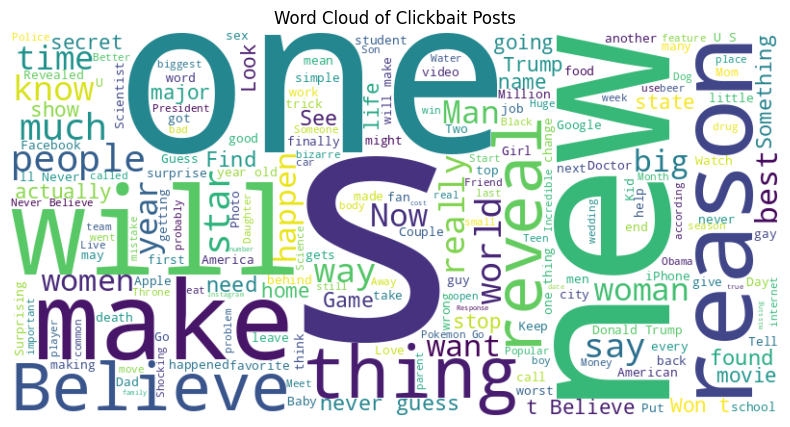

In [103]:
text = " ".join(X_train)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud of Clickbait Posts")
plt.show()

### Text Length Distribution of Clickbait Posts


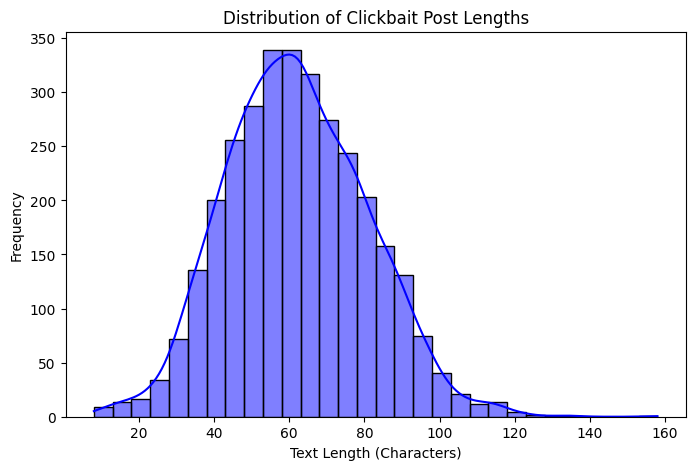

In [104]:
train_df["post_length"] = X_train.apply(len)
plt.figure(figsize=(8, 5))
sns.histplot(train_df["post_length"], bins=30, kde=True, color="blue")
plt.xlabel("Text Length (Characters)")
plt.ylabel("Frequency")
plt.title("Distribution of Clickbait Post Lengths")
plt.show()

###  Comparison of Spoiler vs Clickbait Text Lengths


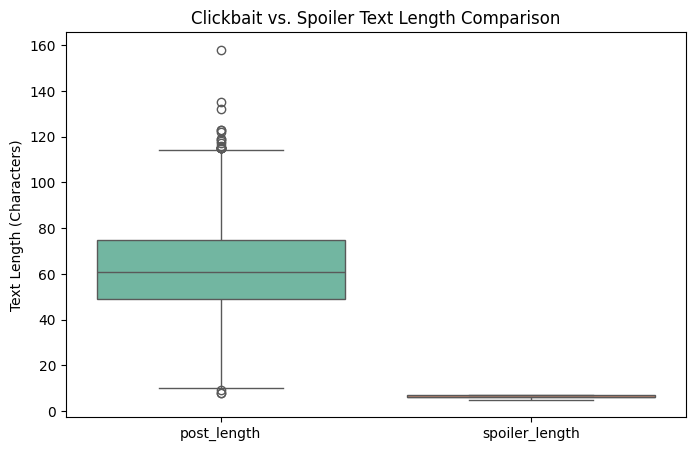

In [105]:
train_df["spoiler_length"] = y_train.apply(len)
plt.figure(figsize=(8, 5))
sns.boxplot(data=train_df[['post_length', 'spoiler_length']], palette="Set2")
plt.ylabel("Text Length (Characters)")
plt.title("Clickbait vs. Spoiler Text Length Comparison")
plt.show()

In [106]:
print(train_df['tags'].value_counts())
print(val_df['tags'].value_counts())

tags
phrase     1367
passage    1274
multi       559
Name: count, dtype: int64
tags
phrase     335
passage    322
multi      143
Name: count, dtype: int64


In [108]:
# Print label distribution
print(" Training Data Tag Distribution:\n", train_df['tags'].value_counts())
print("\n Validation Data Tag Distribution:\n", val_df['tags'].value_counts())

 Training Data Tag Distribution:
 tags
phrase     1367
passage    1274
multi       559
Name: count, dtype: int64

 Validation Data Tag Distribution:
 tags
phrase     335
passage    322
multi      143
Name: count, dtype: int64


In [111]:
# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=set(y_true), yticklabels=set(y_true))
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()

# Logistic Regression



Training Logistic Regression...
Evaluating Logistic Regression on validation data:
Accuracy: 0.5675
              precision    recall  f1-score   support

       multi       0.79      0.24      0.37       143
     passage       0.56      0.61      0.58       322
      phrase       0.55      0.67      0.61       335

    accuracy                           0.57       800
   macro avg       0.63      0.50      0.52       800
weighted avg       0.60      0.57      0.55       800



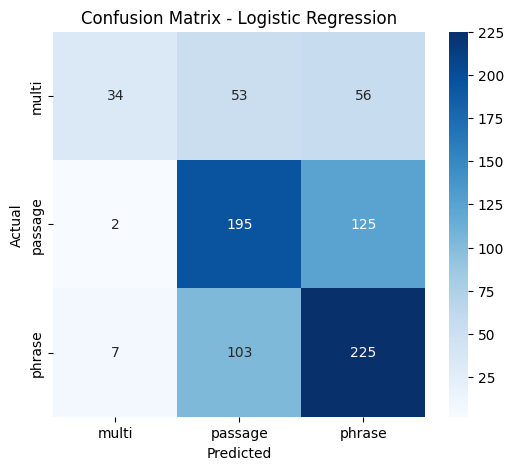

In [112]:
print("\nTraining Logistic Regression...")
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train_tfidf, y_train)
print("Evaluating Logistic Regression on validation data:")
y_pred_lr = lr_model.predict(X_valid_tfidf)
print(f"Accuracy: {accuracy_score(y_valid, y_pred_lr):.4f}")
print(classification_report(y_valid, y_pred_lr))
plot_confusion_matrix(y_valid, y_pred_lr, "Logistic Regression")

# Naïve Bayes



Training Naïve Bayes...
Evaluating Naïve Bayes on validation data:
Accuracy: 0.5400
              precision    recall  f1-score   support

       multi       0.94      0.10      0.19       143
     passage       0.54      0.56      0.55       322
      phrase       0.52      0.71      0.60       335

    accuracy                           0.54       800
   macro avg       0.67      0.46      0.45       800
weighted avg       0.61      0.54      0.51       800



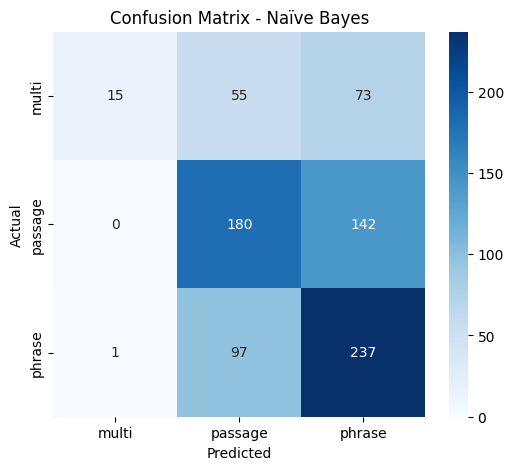

In [114]:
print("\nTraining Naïve Bayes...")
nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)
print("Evaluating Naïve Bayes on validation data:")
y_pred_nb = nb_model.predict(X_valid_tfidf)
print(f"Accuracy: {accuracy_score(y_valid, y_pred_nb):.4f}")
print(classification_report(y_valid, y_pred_nb))
plot_confusion_matrix(y_valid, y_pred_nb, "Naïve Bayes")

# SVM


Training SVM...
Evaluating SVM on validation data:
Accuracy: 0.5700
              precision    recall  f1-score   support

       multi       0.84      0.18      0.30       143
     passage       0.56      0.61      0.58       322
      phrase       0.56      0.70      0.62       335

    accuracy                           0.57       800
   macro avg       0.65      0.50      0.50       800
weighted avg       0.61      0.57      0.55       800



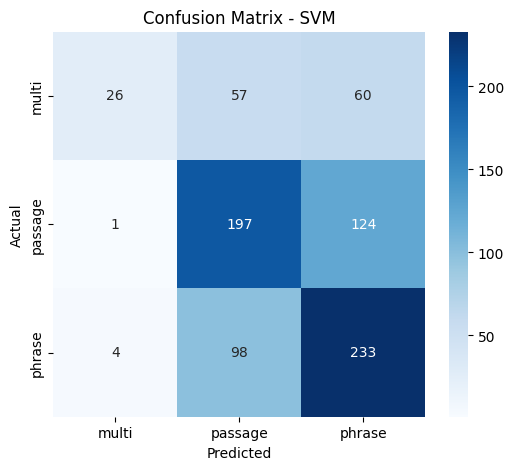

In [115]:
print("\nTraining SVM...")
svm_model = SVC()
svm_model.fit(X_train_tfidf, y_train)
print("Evaluating SVM on validation data:")
y_pred_svm = svm_model.predict(X_valid_tfidf)
print(f"Accuracy: {accuracy_score(y_valid, y_pred_svm):.4f}")
print(classification_report(y_valid, y_pred_svm))
plot_confusion_matrix(y_valid, y_pred_svm, "SVM")

# Random Forest



Training Random Forest...
Evaluating Random Forest on validation data:
Accuracy: 0.5587
              precision    recall  f1-score   support

       multi       0.73      0.28      0.40       143
     passage       0.54      0.66      0.59       322
      phrase       0.56      0.59      0.57       335

    accuracy                           0.56       800
   macro avg       0.61      0.51      0.52       800
weighted avg       0.58      0.56      0.55       800



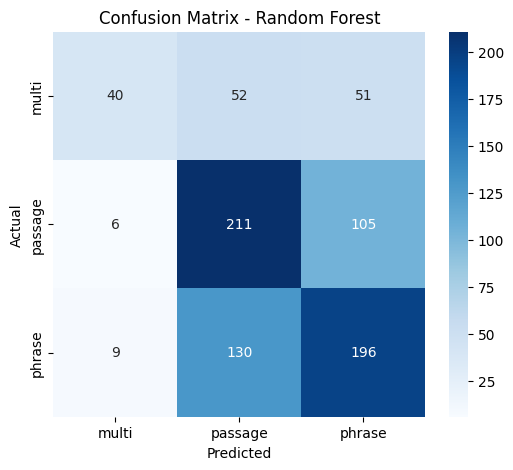

In [116]:
print("\nTraining Random Forest...")
rf_model = RandomForestClassifier()
rf_model.fit(X_train_tfidf, y_train)
print("Evaluating Random Forest on validation data:")
y_pred_rf = rf_model.predict(X_valid_tfidf)
print(f"Accuracy: {accuracy_score(y_valid, y_pred_rf):.4f}")
print(classification_report(y_valid, y_pred_rf))
plot_confusion_matrix(y_valid, y_pred_rf, "Random Forest")

# Model Comparison

<ipython-input-120-c25ee21ba78f>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(model_accuracies.keys()), y=list(model_accuracies.values()), palette="viridis")


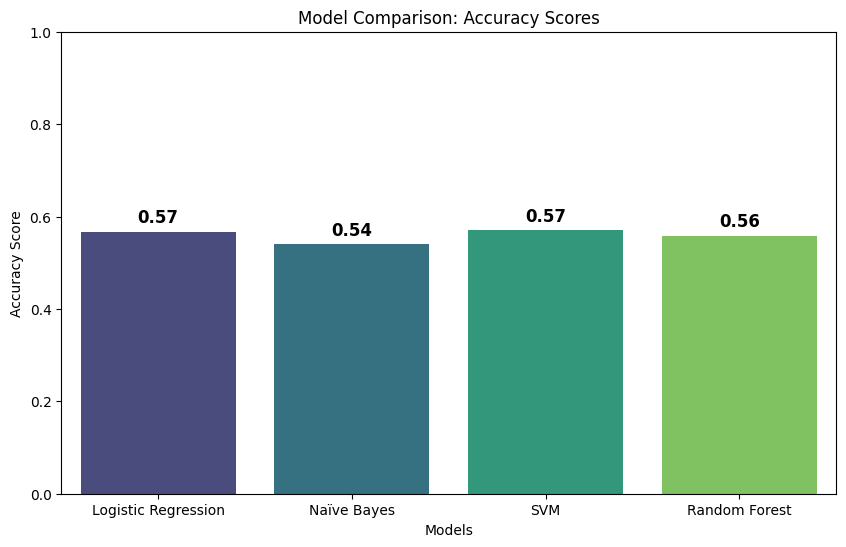

In [120]:
# Dictionary to store accuracy scores
model_accuracies = {
    "Logistic Regression": round(accuracy_score(y_valid, y_pred_lr), 4),
    "Naïve Bayes": round(accuracy_score(y_valid, y_pred_nb), 4),
    "SVM": round(accuracy_score(y_valid, y_pred_svm), 4),
    "Random Forest": round(accuracy_score(y_valid, y_pred_rf), 4),
}

### Model Comparison Bar Plot ###
plt.figure(figsize=(10, 6))
sns.barplot(x=list(model_accuracies.keys()), y=list(model_accuracies.values()), palette="viridis")
plt.ylim(0, 1)  # Accuracy values range between 0 and 1
plt.ylabel("Accuracy Score")
plt.xlabel("Models")
plt.title("Model Comparison: Accuracy Scores")

# Add accuracy scores on top of bars
for i, v in enumerate(model_accuracies.values()):
    plt.text(i, v + 0.02, f"{v:.2f}", ha="center", fontsize=12, fontweight="bold")

plt.show()